# Explaining Quantitative Measures of Fairness

This notebook explores how SHAP can be used to explain quantitative measures of fairness, and so enhance their usefulness.

In [7]:
# this is used for plotting the SHAP value explanations of the group differences
def group_difference_plot(shap_values, group_mask, feature_names, xlabel=None, xmin=None, xmax=None, show=True):
    
    # compute confidence bounds for the group difference value
    vs = []
    gmean = group_mask.mean()
    for i in range(1000):
        r = np.random.rand(shap_values.shape[0]) > gmean
        vs.append(shap_values[r].mean(0) - shap_values[~r].mean(0))
    vs = np.array(vs)
    xerr = np.vstack([np.percentile(vs, 95, axis=0), np.percentile(vs, 5, axis=0)])
    
    # draw the figure
    pl.figure()
    ticks = range(shap_values.shape[1]-1, -1, -1)
    pl.axvline(0, color="#999999", linewidth=0.5)
    pl.barh(
        ticks, shap_values[group_mask].mean(0) - shap_values[~group_mask].mean(0), color=shap.plots.colors.blue_rgb,
        capsize=3, xerr=np.abs(xerr)
    )
    
    for i in range(shap_values.shape[1]):
        pl.axhline(y=i, color="#cccccc", lw=0.5, dashes=(1, 5), zorder=-1)
    
    ax = pl.gca()
    ax.set_yticklabels(feature_names)
    ax.xaxis.set_ticks_position('bottom')
    ax.yaxis.set_ticks_position('none')
    ax.spines['right'].set_visible(False)
    ax.spines['top'].set_visible(False)
    ax.spines['left'].set_visible(False)
    ax.tick_params(labelsize=11)
    if xlabel is None:
        xlabel = "Group SHAP value difference"
    ax.set_xlabel(xlabel, fontsize=13)
    pl.yticks(ticks, fontsize=13)
    xlim = list(pl.xlim())
    if xmin is not None:
        xlim[0] = xmin
    if xmax is not None:
        xlim[1] = xmax
    pl.xlim(*xlim)
    if show:
        pl.show()

 97%|=================== | 9681/10000 [00:11<00:00]       

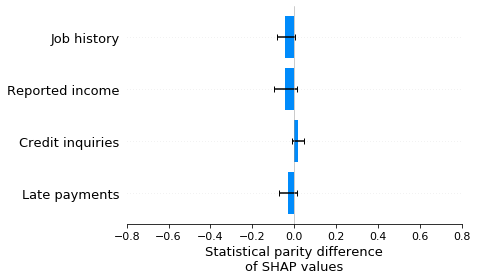

 96%|=================== | 9620/10000 [00:11<00:00]       

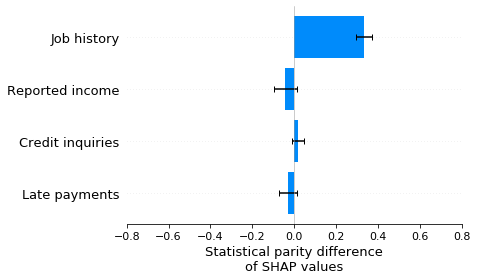

 96%|=================== | 9597/10000 [00:11<00:00]       

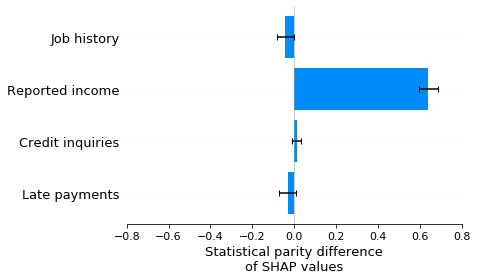

 96%|=================== | 9635/10000 [00:11<00:00]       

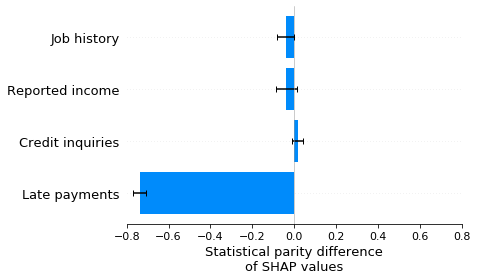

In [8]:
# build data
import scipy as sp
import numpy as np
import shap
import matplotlib.pyplot as pl
import pandas as pd

def run_credit_experiment(N, job_history_sex_impact=0, reported_income_sex_impact=0, late_payments_sex_impact=0):
    np.random.seed(0)
    sex = np.random.randint(0, 2, N) == 1
    income_stability = np.random.rand(N)
    income_amount = np.random.rand(N)
    spending_restraint = np.random.rand(N)
    consistency = np.random.rand(N)
    profitability = income_stability * income_amount * spending_restraint * consistency
    
    job_history = np.maximum(10 * income_stability + 2 * np.random.rand(N) - job_history_sex_impact * sex * np.random.rand(N), 0)
    reported_income =  np.maximum(10000 + 90000*income_amount + np.random.randn(N) * 10000 - reported_income_sex_impact * sex * np.random.rand(N), 0)
    credit_inquiries = np.round(6 * np.maximum(spending_restraint - income_amount, 0)) + np.round(np.random.rand(N) > 0.1)
    late_payments = np.maximum(np.round(3 * np.maximum((1-consistency) + 0.2 * (1-income_stability), 0)) + np.round(np.random.rand(N) > 0.1) - np.round(late_payments_sex_impact * sex * np.random.rand(N)), 0)

    X = pd.DataFrame({
        "Job history": job_history,
        "Reported income": reported_income,
        "Credit inquiries": credit_inquiries,
        "Late payments": late_payments
    })
    y = profitability > np.percentile(profitability, 60)

    # build model
    import xgboost
    model = xgboost.XGBClassifier(max_depth=1, n_estimators=500, subsample=0.5, learning_rate=0.05)
    model.fit(X, y)

    # build explanation
    import shap
    explainer = shap.TreeExplainer(model, shap.sample(X, 100))
    shap_values = explainer.shap_values(X)
    
    return shap_values, sex, X, explainer.expected_value

N = 10000
xmin = -0.8
xmax = 0.8
xlabel = "Statistical parity difference\nof SHAP values"
shap_values1, sex1, X1, ev1 = run_credit_experiment(N)
group_difference_plot(shap_values1, ~sex1, X1.columns, xmin=xmin, xmax=xmax, xlabel=xlabel)
#pl.savefig("./none.pdf")

shap_values2, sex2, X2, ev2 = run_credit_experiment(N, job_history_sex_impact=2)
group_difference_plot(shap_values2, ~sex2, X2.columns, xmin=xmin, xmax=xmax, xlabel=xlabel)
#pl.savefig("./job_history.pdf")

shap_values3, sex3, X3, ev3 = run_credit_experiment(N, reported_income_sex_impact=30000)
group_difference_plot(shap_values3, ~sex3, X3.columns, xmin=xmin, xmax=xmax, xlabel=xlabel)
#pl.savefig("./reported_income.pdf")

shap_values4, sex4, X4, ev4 = run_credit_experiment(N, late_payments_sex_impact=2)
group_difference_plot(shap_values4, ~sex4, X4.columns, xmin=xmin, xmax=xmax, xlabel=xlabel)
#pl.savefig("./late_payments.pdf")

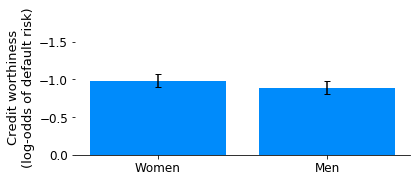

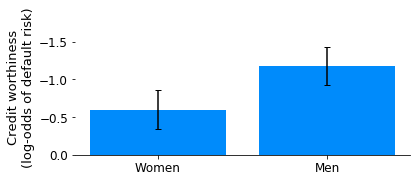

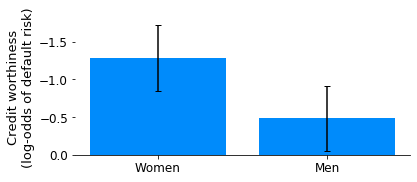

In [11]:
# this plots the overall group difference plots
def group_output_plot(outputs, group_mask, group_names=["True", "False"]):
    vs = []
    gmean = group_mask.mean()
    for i in range(1000):
        r = np.random.rand(len(outputs)) > gmean
        vs.append([outputs[r].mean(0), outputs[~r].mean(0)])
    vs = np.array(vs)
    xerr = np.vstack([np.percentile(vs, 95, axis=0), np.percentile(vs, 5, axis=0)])
    pl.figure(figsize=[6.0, 2.5])
    xerr[0] -= outputs[group_mask].mean()
    xerr[1] -= outputs[~group_mask].mean()
    xerr = np.abs(xerr) 
    pl.bar(
        range(2),
        [outputs[group_mask].mean(), outputs[~group_mask].mean()],
        color=shap.plots.colors.blue_rgb, yerr=xerr.T, capsize=3
    )
    ax = pl.gca()
    ax.spines['right'].set_visible(False)
    ax.spines['top'].set_visible(False)
    ax.spines['left'].set_visible(False)
    ax.invert_yaxis()
    ax.set_xticks([0,1])
    ax.set_xticklabels(group_names)
    ax.tick_params(labelsize=12)
    pl.ylabel("Credit worthiness\n(log-odds of default risk)", fontsize=13)
    pl.ylim(0, -1.8)
    pl.show()
group_output_plot(ev1 + shap_values1.sum(1), ~sex1, ["Women", "Men"])
#pl.savefig("./overall_none.pdf")
group_output_plot(ev3 + shap_values3.sum(1), ~sex3, ["Women", "Men"])
#pl.savefig("./overall_reported_income.pdf")
group_output_plot(ev4 + shap_values4.sum(1), ~sex4, ["Women", "Men"])
#pl.savefig("./overall_late_payments.pdf")